### AirPassengers

##### Box_Jenkins ARIMA Procedure
1. Data Processing
2. Identify Model to be Tentatively Entertained
3. Estimate Parameters
4. Diagnosis Check
5. User Model to Forecast

##### 1. Data processing

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


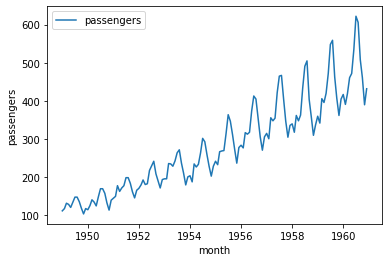

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("data/AirPassengers.csv")
df.rename(columns={"Month" : "month", "#Passengers" : "passengers"}, inplace=True)
df["month"] = pd.to_datetime(df["month"])
df.set_index("month", inplace=True)
# plt.figure(dpi=150)
plt.xlabel("month")
plt.ylabel("passengers")
plt.plot(df, label="passengers")
plt.legend()
display(df)

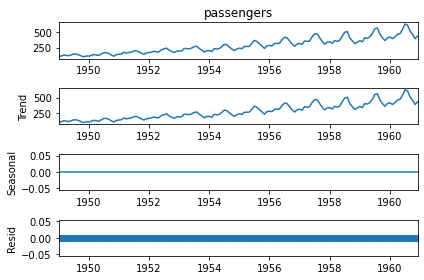

In [3]:
import statsmodels.api as sm
#Decomposition of Time Series
decomposition = sm.tsa.seasonal_decompose(df["passengers"], model="additive", period=1)
fig = decomposition.plot()
# fig.dpi = 150
# fig.set_size_inches(10, 15)
plt.show()

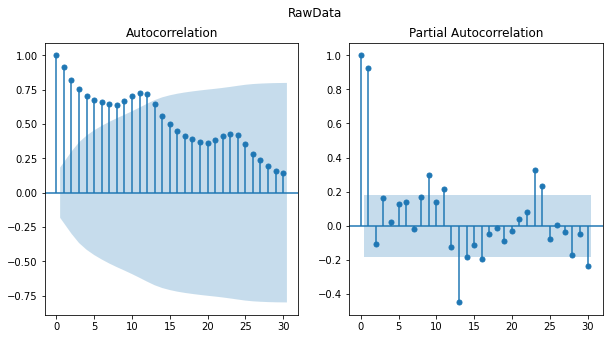

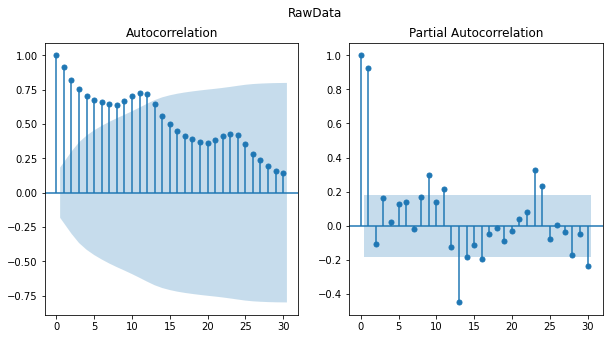

In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("RawData")
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

#비정상성 시계열의 전형적인 특징을 보여준다. 완만히 하강하는 모양새. 정상성이라면 뚝 끊기게 나올 것

month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


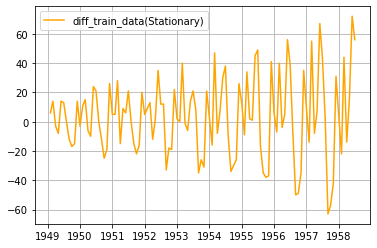

In [5]:
#차분한다.
diff_train_data = train_data.copy()
diff_train_data = diff_train_data["passengers"].diff()
diff_train_data.dropna(inplace=True)
print(diff_train_data)
# help(plt.Figure)
# plt.figure(dpi=150, figsize=(10,5))
plt.plot(diff_train_data, "orange", label="diff_train_data(Stationary)")
plt.grid()
plt.legend()

/Users/hrdkdh/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


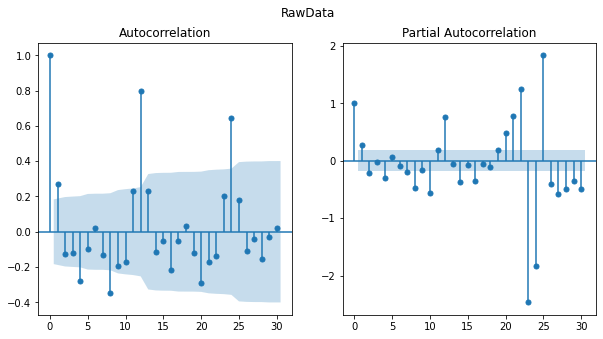

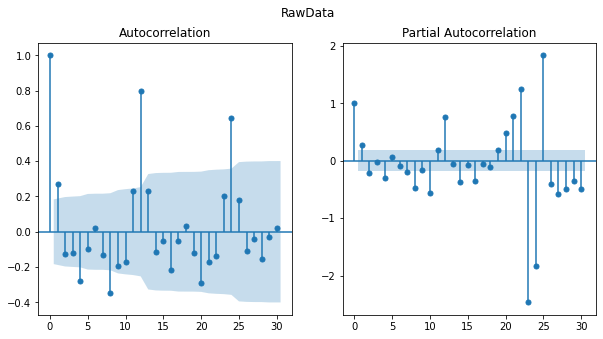

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("RawData")
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

#정상성을 보이는 것으로 보임. 3~4개 튀는 것들이 있으나 무시해도 좋음

##### 2. Identify Model to be Tentativery Entertained
![title](images/arima_model_selection.png)

In [7]:
import itertools
import warnings
warnings.filterwarnings("ignore")

#원래는 위 표에 따라 p,d,q를 결정해야 하지만 iterative 하게 할거임
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q)) #세가지 배열의 값을 각각 조합하여 새로운 배열로 만들어 줌

aic = []
for i in pdq:
    model = sm.tsa.ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print("ARIMA Order : {} -> AIC : {}".format(i, model_fit.aic))
    aic_dict = { "order": i, "aic" : model_fit.aic }
    aic.append(aic_dict)

result_by_aic = pd.DataFrame(aic)
result_by_aic.sort_values(by="aic", ascending=True, inplace=True)
result_by_aic.reset_index(inplace=True)
result_by_aic

ARIMA Order : (0, 1, 0) -> AIC : 1076.518771084965
ARIMA Order : (0, 1, 1) -> AIC : 1064.6239195875546
ARIMA Order : (0, 1, 2) -> AIC : 1061.077902121634
ARIMA Order : (1, 1, 0) -> AIC : 1069.439939269566
ARIMA Order : (1, 1, 1) -> AIC : 1058.8346607202006
ARIMA Order : (1, 1, 2) -> AIC : 1046.052133926064
ARIMA Order : (2, 1, 0) -> AIC : 1066.2025865824053
ARIMA Order : (2, 1, 1) -> AIC : 1045.659590615217
ARIMA Order : (2, 1, 2) -> AIC : 1047.1931157680726


,index,order,aic
0,7,"(2, 1, 1)",1045.659591
1,5,"(1, 1, 2)",1046.052134
2,8,"(2, 1, 2)",1047.193116
3,4,"(1, 1, 1)",1058.834661
4,2,"(0, 1, 2)",1061.077902
5,1,"(0, 1, 1)",1064.623920
6,6,"(2, 1, 0)",1066.202587
7,3,"(1, 1, 0)",1069.439939
8,0,"(0, 1, 0)",1076.518771


In [8]:
#aic가 가장 낮은 모델로 select 하여 summary를 본다
model_opt = sm.tsa.ARIMA(train_data.values, order=result_by_aic.iloc[0,1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Fri, 10 Sep 2021   AIC                           1045.660
Time:                        16:09:00   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.163     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

##### 3. Use Model to Forecast

Text(0.5, 0.98, 'ARIMA (2, 1, 1) Prediction Results (r2_score : 0.22)')

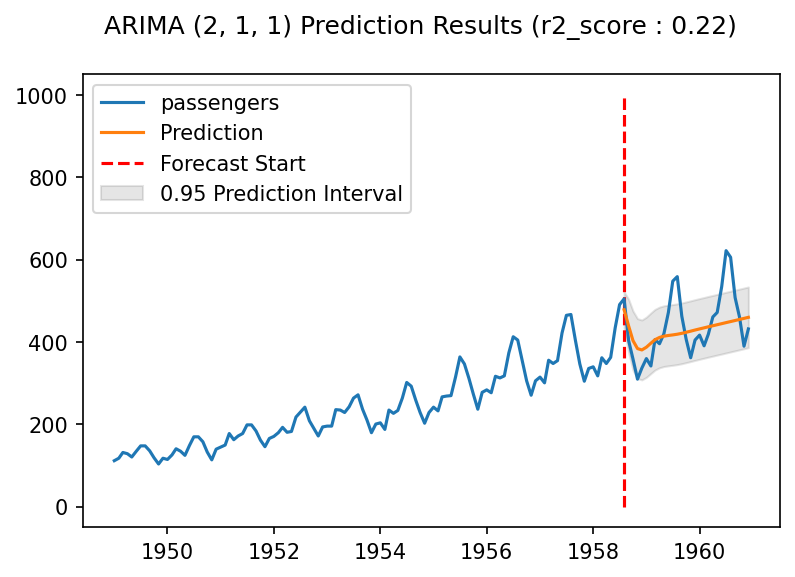

In [9]:
import datetime
import numpy as np
from sklearn.metrics import r2_score

prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

forecast_start_date = datetime.datetime(1958, 8, 1)
forecast_start_date = np.datetime64(forecast_start_date)
plt.figure(dpi=150)
plt.plot(df.index, df["passengers"], label="passengers")
plt.vlines(forecast_start_date, 0, 1000, linestyle="--", color="r", label="Forecast Start")
plt.plot(predict_index, predicted_value, label = "Prediction")
plt.fill_between(predict_index, predicted_lb, predicted_ub, color="k", alpha=0.1, label="0.95 Prediction Interval")
plt.legend(loc="upper left")
plt.suptitle("ARIMA {} Prediction Results (r2_score : {:4.2f})".format(result_by_aic.iloc[0,1], r2))

##### ※SARIMA도 해보자

In [10]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q)) #세가지 배열의 값을 각각 조합하여 새로운 배열로 만들어 줌
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

aic = []
for i in pdq:
    for j in seasonal_pdq:
        try: #pdq 파라미터 값 때문에 오류가 날 수 있음. 코드가 중단되므로 try문으로...
            model = sm.tsa.SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print("SARIMA Order : {}{} -> AIC : {}".format(i, j, model_fit.aic))
            aic_dict = { "pdq": i, "s-pdq" : j, "aic" : model_fit.aic }
            aic.append(aic_dict)
        except:
            continue
result_by_aic = pd.DataFrame(aic)
result_by_aic.sort_values(by="aic", ascending=True, inplace=True)
result_by_aic.reset_index(inplace=True)
result_by_aic

SARIMA Order : (0, 1, 0)(0, 1, 0, 12) -> AIC : 757.8259224783303
SARIMA Order : (0, 1, 0)(0, 1, 1, 12) -> AIC : 756.9881631127478
SARIMA Order : (0, 1, 0)(0, 1, 2, 12) -> AIC : 758.8259472285863
SARIMA Order : (0, 1, 0)(1, 1, 0, 12) -> AIC : 756.9591640166154
SARIMA Order : (0, 1, 0)(1, 1, 1, 12) -> AIC : 758.9218654185844
SARIMA Order : (0, 1, 0)(1, 1, 2, 12) -> AIC : 754.4220149011858
SARIMA Order : (0, 1, 0)(2, 1, 0, 12) -> AIC : 758.8687859500429
SARIMA Order : (0, 1, 0)(2, 1, 1, 12) -> AIC : 760.7258189335555
SARIMA Order : (0, 1, 0)(2, 1, 2, 12) -> AIC : 754.8912551448777
SARIMA Order : (0, 1, 1)(0, 1, 0, 12) -> AIC : 756.0113506849506
SARIMA Order : (0, 1, 1)(0, 1, 1, 12) -> AIC : 756.3802818130979
SARIMA Order : (0, 1, 1)(0, 1, 2, 12) -> AIC : 757.6530313361227
SARIMA Order : (0, 1, 1)(1, 1, 0, 12) -> AIC : 756.1655758988336
SARIMA Order : (0, 1, 1)(1, 1, 1, 12) -> AIC : 758.1068769349343
SARIMA Order : (0, 1, 1)(1, 1, 2, 12) -> AIC : 751.7281804283629
SARIMA Order : (0, 1, 1)(

,index,pdq,s-pdq,aic
0,32,"(1, 1, 0)","(1, 1, 2, 12)",751.149126
1,14,"(0, 1, 1)","(1, 1, 2, 12)",751.728180
2,73,"(2, 1, 2)","(1, 1, 2, 12)",752.330142
3,40,"(1, 1, 1)","(1, 1, 2, 12)",752.533710
4,56,"(2, 1, 0)","(1, 1, 2, 12)",752.773786
...,...,...,...,...
71,64,"(2, 1, 1)","(1, 1, 1, 12)",760.182764
72,17,"(0, 1, 1)","(2, 1, 2, 12)",760.440590
73,7,"(0, 1, 0)","(2, 1, 1, 12)",760.725819
74,26,"(0, 1, 2)","(2, 1, 2, 12)",761.971698


In [11]:
#aic가 가장 낮은 모델로 select 하여 summary를 본다
model_opt = sm.tsa.SARIMAX(train_data.values, order=result_by_aic.iloc[0,1], seasonal_order=result_by_aic.iloc[0,2])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.575
Date:                                 Fri, 10 Sep 2021   AIC                            751.149
Time:                                         16:10:02   BIC                            764.274
Sample:                                              0   HQIC                           756.464
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2364      0.093     -2.545      0.011      -0.419      -0.054
ar.S.L12       0.9982      0.191      5.238      0.000       0.625       1.372
ma.S.L12      -1.3651      2.188     -0.624      0.533      -5.654       2.923
ma.S.L24       0.3923      0.768      0.511      0.610      -1.114       1.898
sigma2        70.1487    140.968      0.498      0.619    -206.144     346.441
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.88   Prob(JB):                         0.25
Heteroskedasticity (H):               1.10   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0.98, 'ARIMA (1, 1, 0) Prediction Results (r2_score : 0.89)')

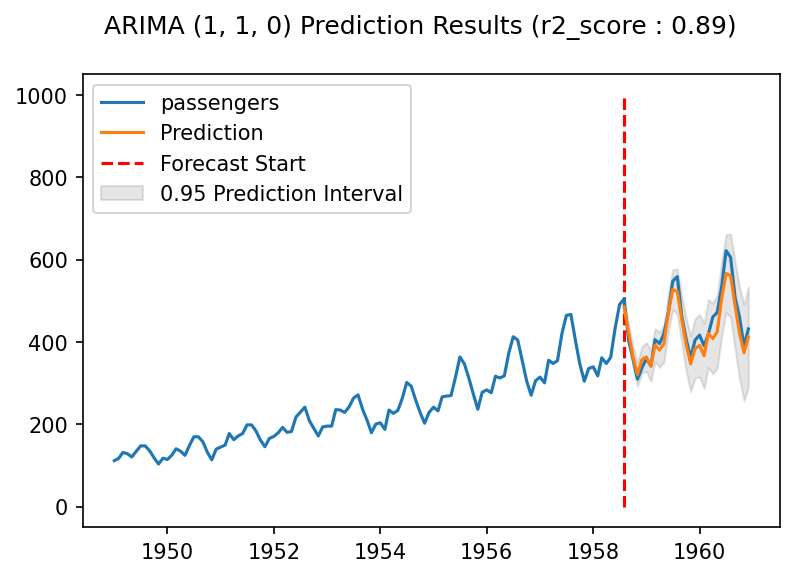

In [13]:
import datetime
import numpy as np
from sklearn.metrics import r2_score

prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

forecast_start_date = datetime.datetime(1958, 8, 1)
forecast_start_date = np.datetime64(forecast_start_date)
plt.figure(dpi=150)
plt.plot(df.index, df["passengers"], label="passengers")
plt.vlines(forecast_start_date, 0, 1000, linestyle="--", color="r", label="Forecast Start")
plt.plot(predict_index, predicted_value, label = "Prediction")
plt.fill_between(predict_index, predicted_lb, predicted_ub, color="k", alpha=0.1, label="0.95 Prediction Interval")
plt.legend(loc="upper left")
plt.suptitle("SARIMA {} {}, Prediction Results (r2_score : {:4.2f})".format(result_by_aic.iloc[0,1], result_by_aic.iloc[0,2], r2))

##### ※auto_arima로 SARIMA 구현

In [ ]:
#SARIMA - auto_arima로 한방에 모델 셀렉션이 가능
from pmdarima import auto_arima
aa_model = auto_arima(train_data,
                      start_p=0,
                      d=1,
                      start_q=0,
                      max_p=3,
                      max_d=3,
                      max_q=3,
                      start_P=0,
                      D=1,
                      start_Q=0,
                      max_P=3,
                      max_D=3,
                      max_Q=3,
                      m=12,
                      seasonal=True,
                      trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=False)
aa_model.summary()